# Project 4 - Advanced Lane Finding

## Introduction

In this project, we apply advanced Computer Vision techniques to obtain more accurate and robust lane markings in images and video feeds.

---

In [1]:
import os
import math
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import display, HTML
%matplotlib inline

In [2]:
def get_output_dir():
    output_dir = './output_images'
    
    if not os.path.isdir(output_dir):
        os.mkdir(output_dir)
        
    return output_dir

def get_doc_dir():
    output_dir = './res'
    
    if not os.path.isdir(output_dir):
        os.mkdir(output_dir)
        
    return output_dir
def save_doc_img(img, name):
    mpimg.imsave(os.path.join(get_doc_dir(), name + '.jpg'), img)

## Camera calibration
The first step is to perform camera calibration, to obtain the camera calibration matrix and the distorsion coefficients.

### Extract chessboard corners

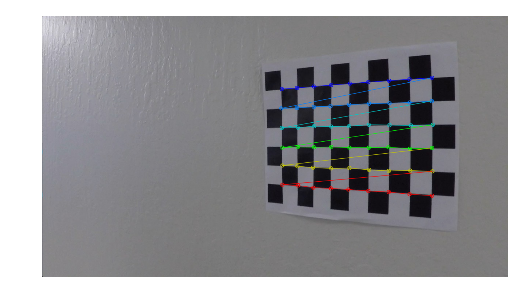

In [3]:
# Path to calibration images
calibration_images_paths = glob.glob('./camera_cal/*.jpg')

# Number of squares in X and Y direction
nx = 9
ny = 6

# Define object points for each image. We assume that each square
# has a size of 1 meter, and the origin is the top-left corner
# of the first square.
obj_pts_i = np.zeros((nx*ny, 3), np.float32)
obj_pts_i[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Declare obj and img points
obj_pts = []
img_pts = []

plotted_img = False

# Loop over images
for img_path in calibration_images_paths:
    # Read image
    img = mpimg.imread(img_path)
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Find checkboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        # Add points to list
        img_pts.append(corners)
        obj_pts.append(obj_pts_i)
        
        # Draw resulting corners for the first image
        if not plotted_img:
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            plt.imshow(img);
            plt.axis('off');
            save_doc_img(img, 'checkerboard_corners')
            plotted_img = True
    else:
        print('Warning: could not extract checkboard points from %s.' % img_path)

### Get calibration coefficients

In [4]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_pts, img_pts, gray.shape[::-1],None,None)

## Image undistortion

In [5]:
def undistort_img(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

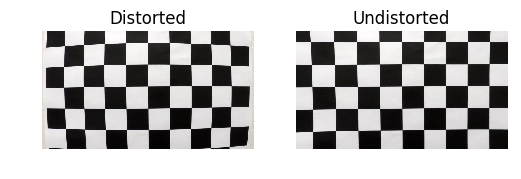

In [6]:
test_img = './camera_cal/calibration1.jpg'
img = mpimg.imread(test_img)
plt.subplot(1,2,1);
plt.imshow(img);
plt.title('Distorted')
plt.axis('off');
plt.subplot(1,2,2);
img_undistorted = undistort_img(img)
plt.imshow(undistort_img(img));
plt.title('Undistorted')
plt.axis('off');

# Save for documentation
save_doc_img(img, 'img_distorted')
save_doc_img(img_undistorted, 'img_undistorted')

## Color spaces

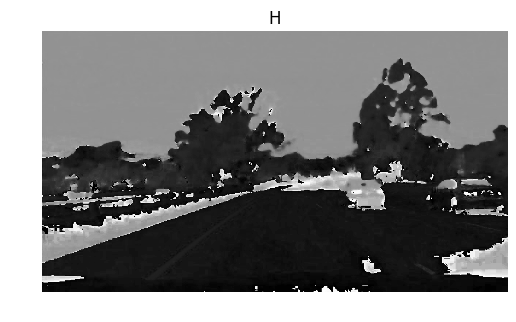

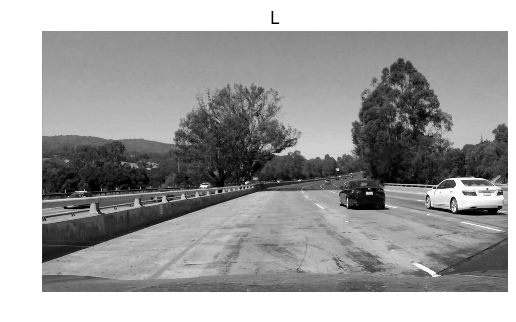

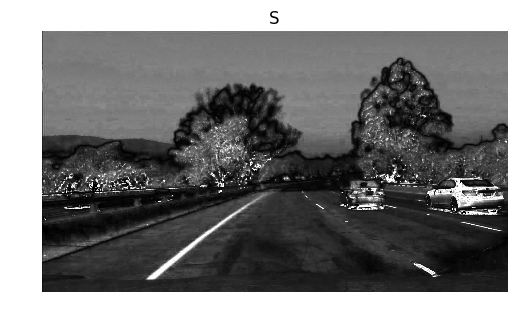

In [7]:
def display_hls(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    titles = ['H', 'L', 'S']
    
    for i in range(len(titles)):
        plt.figure();
        plt.imshow(hls[:, :, i], cmap='gray')
        plt.axis('off')
        plt.title(titles[i])
    
test_img = './test_images/test1.jpg'
img = mpimg.imread(test_img)
display_hls(img)

## Color masks

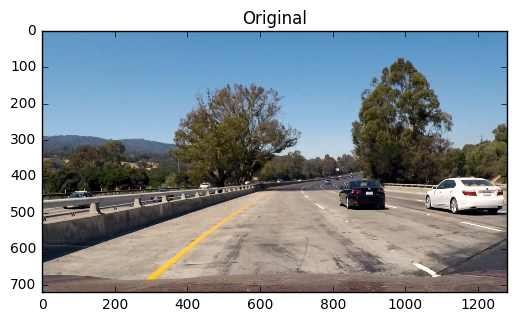

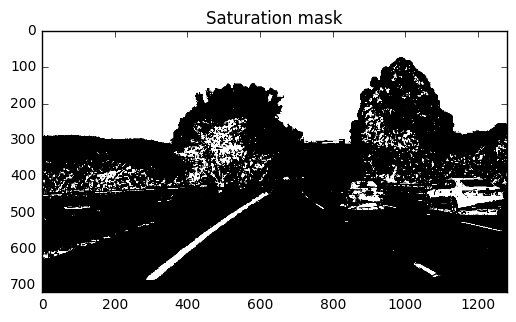

In [8]:
def mask_img(img, thresh):
    binary_output = np.zeros_like(img)
    binary_output[(img >= thresh[0]) & (img <= thresh[1])] = 1
    return binary_output

def mask_to_rgb(img):
    return 255 * np.dstack((img, img, img))

def saturation_mask(img, thresh=(100,255)):
    # Convert to HLS
    img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    # Create saturation mask
    s_mask = mask_img(img_hls[:,:,2], thresh)
    
    return s_mask

test_img = './test_images/test1.jpg'
img = mpimg.imread(test_img)
plt.figure();
plt.imshow(img);
plt.title('Original');
plt.figure();
plt.imshow(saturation_mask(img, thresh = (100,255)), cmap='gray')
plt.title('Saturation mask');

## Gradient masks

In [9]:
def compute_sobel(img, orient, sobel_kernel=3):
     # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    else:
        raise NotImplemented
    
    return sobel

def abs_sobel_mask(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Get sobel
    sobel = compute_sobel(img, orient)
        
    # Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a mask of 1's where the scaled gradient magnitude 
    # is > thresh_min and < thresh_max
    return mask_img(scaled_sobel, thresh)
    
def mag_mask(img, sobel_kernel=3, thresh=(0, 255)):
    # Get sobel in X and Y directions
    sobel_x = compute_sobel(img, orient = 'x')
    sobel_y = compute_sobel(img, orient = 'y')
        
    # Take the absolute value of the derivative or gradient
    sobel_mag = np.sqrt(sobel_x * sobel_x + sobel_y * sobel_y)
    
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*sobel_mag/np.max(sobel_mag))
    
    # Create a mask of 1's where the scaled gradient magnitude 
    # is > thresh_min and < thresh_max
    return mask_img(scaled_sobel, thresh)

def dir_mask(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Get sobel in X and Y directions
    sobel_x = compute_sobel(img, orient = 'x')
    sobel_y = compute_sobel(img, orient = 'y')
        
    # Calculate the absolute direction of the gradient 
    sobel_dir = np.absolute(np.arctan(sobel_y / (sobel_x + 1.e-7)))

    return mask_img(sobel_dir, thresh)

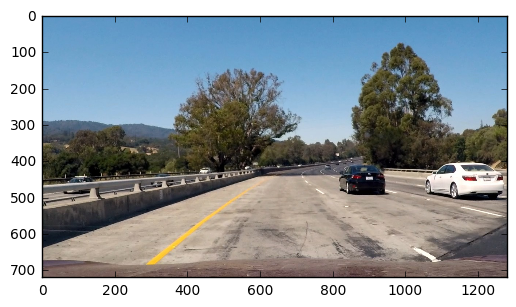

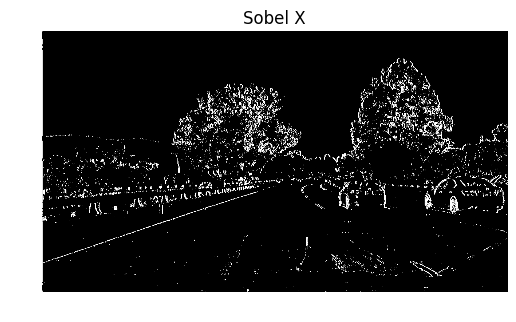

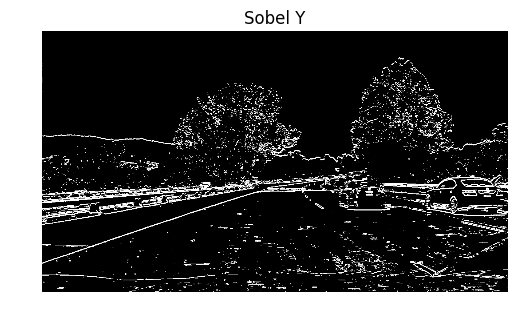

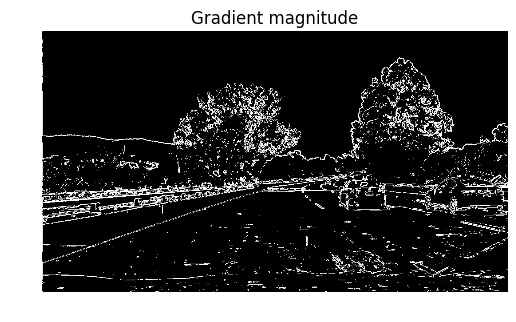

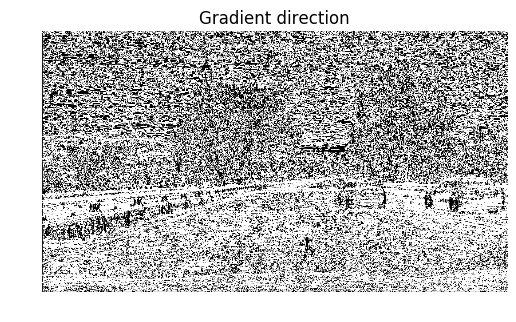

In [10]:
test_img = './test_images/test1.jpg'
img = mpimg.imread(test_img)
plt.figure();
plt.imshow(img);
plt.figure();
plt.imshow(abs_sobel_mask(img, orient = 'x', thresh=(25,255)), cmap='gray');
plt.axis('off');
plt.title('Sobel X');
plt.figure();
plt.imshow(abs_sobel_mask(img, orient = 'y', thresh=(25,255)), cmap='gray');
plt.axis('off');
plt.title('Sobel Y');
plt.figure();
plt.imshow(mag_mask(img, thresh=(30,100)), cmap='gray');
plt.axis('off');
plt.title('Gradient magnitude');
plt.figure();
plt.imshow(dir_mask(img, thresh=(0.7, 2.0)), cmap='gray');
plt.axis('off');
plt.title('Gradient direction');

## Combined mask

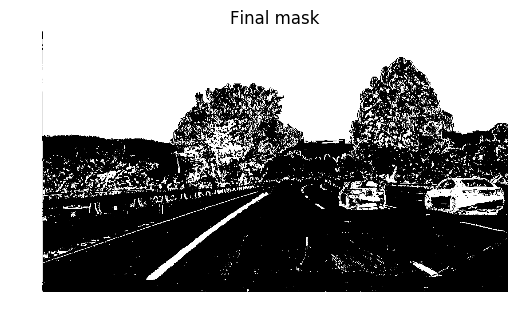

In [11]:
def combined_mask(img):
    # Color masks
    s_mask = saturation_mask(img)
    
    # Gradient masks
    sobel_x_mask = abs_sobel_mask(img, orient = 'x', thresh=(25,255))

    # Final mask
    mask = cv2.bitwise_or(s_mask, sobel_x_mask)
    return mask

test_img = './test_images/test1.jpg'
img = mpimg.imread(test_img)
mask_combined = combined_mask(img)
mask_combined_rgb = mask_to_rgb(mask_combined)
plt.imshow(mask_combined_rgb);
plt.axis('off');
plt.title('Final mask');
save_doc_img(mask_combined_rgb, 'final_mask')

## Perspective transform

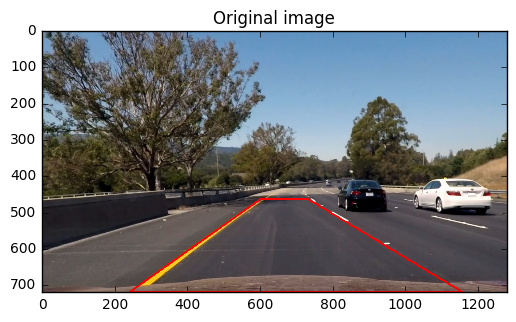

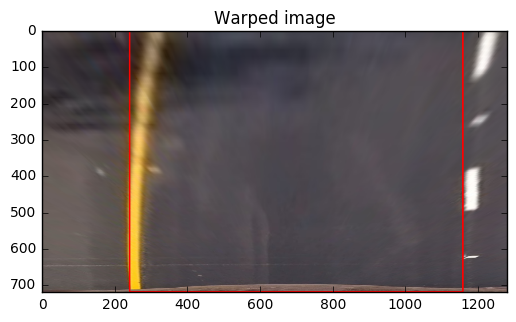

In [12]:
test_img = './test_images/test6.jpg'
img = mpimg.imread(test_img) 
img = undistort_img(img);

k = 1.55
x1 = 240
x2 = 1155
src_pts_ = ((x1, img.shape[0]),
            (x2, img.shape[0]),
            (730, int(img.shape[0]/k)),
            (600, int(img.shape[0]/k)))

dst_pts_ = ((x1, img.shape[0]),
            (x2, img.shape[0]),
            (x2, 0),
            (x1, 0))  


def get_birds_eye_view(img, src_pts=src_pts_, dst_pts=dst_pts_):
    img_size = (img.shape[1], img.shape[0])    
   
    M    = cv2.getPerspectiveTransform(np.float32(src_pts), np.float32(dst_pts))
    Minv = cv2.getPerspectiveTransform(np.float32(dst_pts), np.float32(src_pts))

    return cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR), M, Minv


img_pts = img.copy()
for i in range(4):
    img_pts = cv2.line(img_pts, src_pts_[i], src_pts_[(i+1)%4], color=[255,0,0], thickness=4)
    
    
img_warped,_,_ = get_birds_eye_view(img)
for i in range(4):
    img_warped_pts = cv2.line(img_warped, dst_pts_[i], dst_pts_[(i+1)%4], color=[255,0,0], thickness=4)
    
plt.figure();
plt.imshow(img_pts);
save_doc_img(img_pts, 'persp_transform_original')
plt.title('Original image');
plt.figure();
plt.imshow(img_warped_pts);
save_doc_img(img_warped_pts, 'persp_transform_warped')
plt.title('Warped image');

## Lane pixels detection

Left line at x = 242, right line at x = 1166


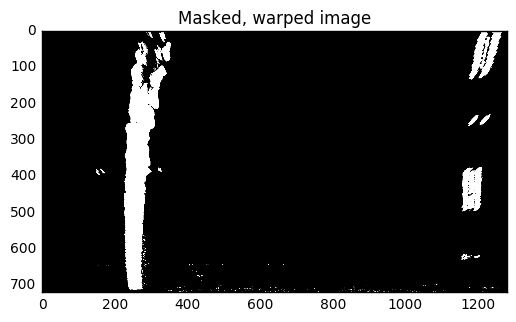

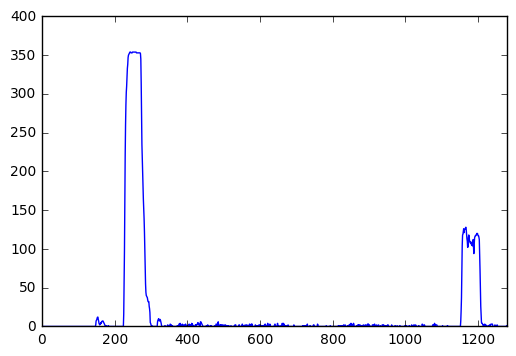

In [13]:
test_img = './test_images/test6.jpg'
img_original = mpimg.imread(test_img) 
img = undistort_img(img_original)
img_warped, M, Minv = get_birds_eye_view(img);
img_mask = combined_mask(img_warped)

def get_starting_x(img, visualize=False):
    # Compute histogram
    histogram = np.sum(img[int(img.shape[0]/2):,:], axis=0)
    
    if visualize:
        plt.plot(histogram);
        plt.autoscale(enable=True, axis='x', tight=True);
        plt.savefig('./res/line_search_initial_point.jpg')
        
    # Get left and right peaks. Assuming that left and right
    # lines will be on the left or right half of the image
    x_half = int(len(histogram)/2)
    x0_left  = np.argmax(histogram[0:x_half])
    x0_right = x_half + np.argmax(histogram[x_half:])
    
    return x0_left, x0_right

plt.figure();
plt.imshow(img_mask, cmap='gray');
plt.title('Masked, warped image');
plt.figure();
x0_left, x0_right = get_starting_x(img_mask, visualize = True)

print('Left line at x = %d, right line at x = %d' % (x0_left, x0_right))

save_doc_img(mask_to_rgb(img_mask), 'before_line_search')


## Lane fitting

In [14]:
class Line():
    def __init__(self):
        # X-Y coordinates of the associated pixels, as a Nx2 vector
        self.pixels_x = []
        self.pixels_y = []
        
        # Coefficients describing the line, in pixel coordinates
        self.coeffs = [0., 0., 0.]
       
        # Coefficients describing the line, in meters
        self.coeffs_m = [0., 0., 0.]

        self.ym_per_pix = 30/720  # meters per pixel in y dimension
        self.xm_per_pix = 3.7/700 # meteres per pixel in x dimension
        
    def fit(self):
        # Fit in pixels
        self.coeffs = np.polyfit(self.pixels_y, self.pixels_x, 2)

        # Fit in meters       
        self.coeffs_m = np.polyfit(self.ym_per_pix * np.array(self.pixels_y),
                                   self.xm_per_pix * np.array(self.pixels_x), 2)       
    
    def update(self, pixels_x, pixels_y):
        # TODO: moving average
        self.pixels_x = pixels_x
        self.pixels_y = pixels_y
        
        self.fit()    
    
    def curvature(self, y_pos_pixels):
        y = y_pos_pixels * self.ym_per_pix
        
        dx_dy   = 2. * self.coeffs_m[0] * y + self.coeffs_m[1]
        d2x_dy2 = 2. * self.coeffs_m[0]
        
        curvature = ((1. + (dx_dy)**2)**1.5) / np.absolute(d2x_dy2)
        return curvature
    
    def get_x_position(self, y_pixels, img_width):
        x_pixels = self.coeffs[0]*(y_pixels**2) + self.coeffs[1]*y_pixels + self.coeffs[2] \
                   - float(img_width)/2
        return self.xm_per_pix * x_pixels    

In [15]:
class Lane():
    def __init__(self):
        self.line_l = Line()
        self.line_r = Line()
        
    def sanity_check(self, img_shape):
        output = True
        
        # Reasonable curvature values
        curv_l = self.line_l.curvature(img_shape[1])
        curv_r = self.line_r.curvature(img_shape[1])
        
        if math.isnan(curv_l) or math.isnan(curv_r) or \
           math.isinf(curv_l) or math.isinf(curv_r):
            output = False
            
        if np.sign(curv_l) != np.sign(curv_r):
            output = False        
        
        # Similar curvature
        r = curv_l / curv_r
        r = max(r, 1/r)
        
        ratio_th = 2.0  # Max acceptable ratio between curvatures
        
        if r > ratio_th:
            output = False
            
        return output        

In [16]:
class SlidingWindow():
    def __init__(self, size_x, size_y, x0, y0):
        self.size_x = size_x
        self.size_y = size_y
        self.x0 = x0
        self.y0 = y0
    
    def get_pixels(self, img):
        pixels_x = []
        pixels_y = []
        
        for x in range(max(0, self.x0), min(img.shape[1], self.x0 + self.size_x)):
            for y in range(max(0, self.y0), min(img.shape[0], self.y0 + self.size_y)):
                if (img[y, x]):
                    pixels_x.append(x)
                    pixels_y.append(y)
                    
        return pixels_x, pixels_y
                    
    def slide(self, delta_x, delta_y):
        self.x0 = self.x0 + delta_x
        self.y0 = self.y0 + delta_y
                    
    def is_point_in_img(self, img, x, y):
        if (x >= 0) and (x < img.shape[1]) and \
           (y >= 0) and (y < img.shape[0]):
            return True
        else:
            return False
        
    def is_inside_img(self, img):
        if self.is_point_in_img(img, self.x0,               self.y0)               or \
           self.is_point_in_img(img, self.x0 + self.size_x, self.y0)               or \
           self.is_point_in_img(img, self.x0,               self.y0 + self.size_y) or \
           self.is_point_in_img(img, self.x0 + self.size_x, self.y0 + self.size_y):
            return True
        else:
            return False
    
    def draw_in_img(self, img):
        points = [(self.x0, self.y0),
                  (self.x0, self.y0 + self.size_y),
                  (self.x0 + self.size_x, self.y0 + self.size_y),
                  (self.x0 + self.size_x, self.y0)]
        
        for i in range(len(points)):
            cv2.line(img, points[i], points[(i + 1)%len(points)], color = (255, 0, 0), thickness = 2)

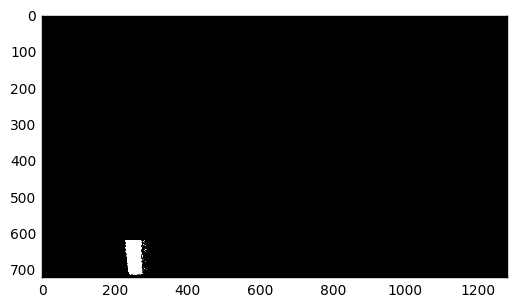

In [17]:
def sliding_window_test(img, x0):
    window = SlidingWindow(100, 100, x0 - 50, img.shape[0] - 1 - 100)
    pixels_x, pixels_y = window.get_pixels(img)
   
    img_out = np.zeros_like(img)
    for i in range(len(pixels_x)):
        img_out[pixels_y[i], pixels_x[i]] = 255
        
    plt.imshow(img_out, cmap='gray')
    
sliding_window_test(img_mask, x0_left)

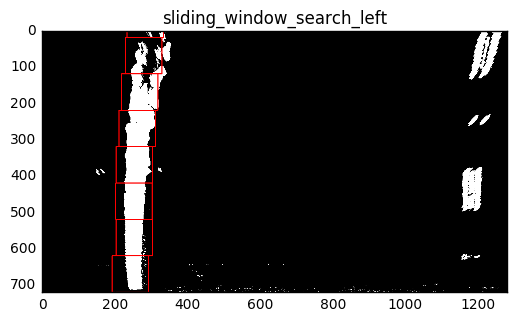

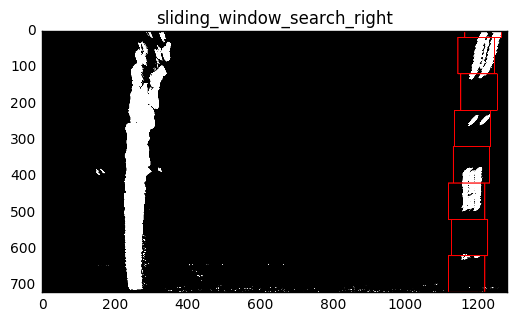

In [18]:
def get_line_pixels(img_masked, x0, visualize = None):
    # Initialize sliding window and line
    out_line = Line()
    size_x = 100
    size_y = 100
    window = SlidingWindow(size_x, size_y, x0 - size_x//2, img_masked.shape[0] - size_y)
    
    if visualize:
        vis_img = 255 * np.copy(img_masked)
        vis_img = np.dstack((vis_img, vis_img, vis_img))
    
    # Go from bottom to top to find the line:
    done = False
    delta_x = 0
    
    while not done:
        # Visualize sliding window
        if visualize:
            window.draw_in_img(vis_img)  
            
        # Get pixels in the sliding window
        pixels_x, pixels_y = window.get_pixels(img_masked)
        
        # Add to line
        out_line.pixels_x = out_line.pixels_x + pixels_x
        out_line.pixels_y = out_line.pixels_y + pixels_y
        
        # Determine where to place the bounding box next. If we don't find pixels
        # in x, we move the previous delta_x assuming that the curvature is the same
        if pixels_x:
            mean_x = int(np.mean(pixels_x))            
            delta_x = (mean_x - window.size_x//2) - window.x0            
        
        delta_y = -window.size_y          
        
        # Move sliding window
        window.slide(delta_x, delta_y)
        
        # We are done if the window is out of the image
        if not window.is_inside_img(img_masked):
            done = True

    if visualize:
        plt.figure();
        plt.imshow(vis_img)
        plt.title(visualize)
        save_doc_img(vis_img, visualize)

    return out_line

get_line_pixels(img_mask, x0_left, 'sliding_window_search_left');
get_line_pixels(img_mask, x0_right, 'sliding_window_search_right');

In [19]:
def get_line_points(img, line):
    n_points = 100
    yvals = np.linspace(0, n_points, num=n_points + 1) * (float(img.shape[0]) / float(n_points))
    xvals = line.coeffs[0]*yvals**2 + line.coeffs[1]*yvals + line.coeffs[2]   
    
    return xvals, yvals

In [20]:
def draw_line(img, line, color = (255,0,0), thickness = 2):
    # Get line points
    xvals, yvals = get_line_points(img, line)

    # Draw line
    for i in range(len(yvals) - 1):
        p1 = (int(xvals[i  ]), int(yvals[i  ]))
        p2 = (int(xvals[i+1]), int(yvals[i+1]))
        
        cv2.line(img, p1, p2, color=color, thickness=thickness)   
    return img

In [21]:
def extract_lane(img_mask):
    # Get starting position for search
    x0_left, x0_right = get_starting_x(img_mask)
    
    # Search for the line
    line_l = get_line_pixels(img_mask, x0_left)
    line_r = get_line_pixels(img_mask, x0_right)
        
    # Fit polynomials to lines
    line_l.fit()
    line_r.fit()
    
    # Encapsulate them into a Lane
    lane = Lane()
    lane.line_l = line_l
    lane.line_r = line_r
    
    return lane

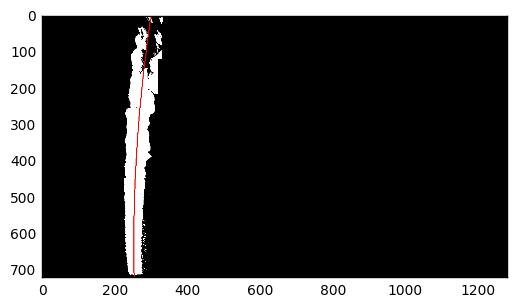

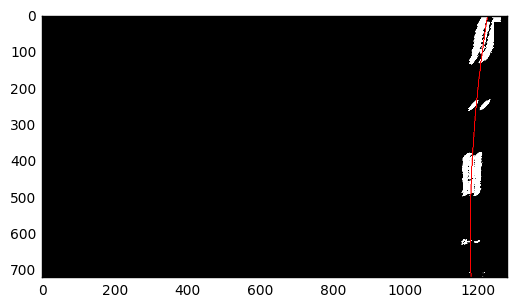

In [22]:
def line_test(img, x0):
    line = get_line_pixels(img, x0)
    line.fit()
    
    img_out = np.zeros_like(img)
    for i in range(len(line.pixels_x)):
        x = line.pixels_x[i]
        y = line.pixels_y[i]

        if (y < img.shape[0]) and (x < img.shape[1]):
            img_out[y][x] = 255

    # Convert to RGB image
    img_out = cv2.cvtColor(img_out, cv2.COLOR_GRAY2RGB)

    # Draw a line representing the fit polynomial
    img_out = draw_line(img_out, line)
    
    plt.figure()            
    plt.imshow(img_out)
    return img_out

save_doc_img(line_test(img_mask, x0_left), 'line_fit_left')
save_doc_img(line_test(img_mask, x0_right), 'line_fit_right')

## Visualization in original image

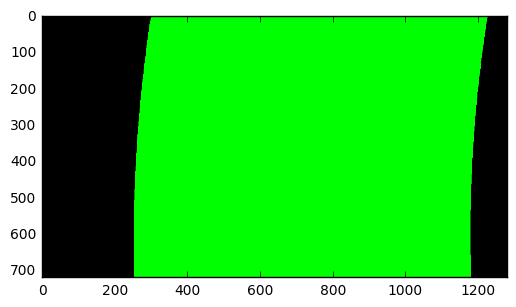

In [23]:
def draw_free_space(img, lane, color = (0, 255, 0)):
    # Get line points
    xvals_l, yvals_l = get_line_points(img, lane.line_l)
    xvals_r, yvals_r = get_line_points(img, lane.line_r)
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([xvals_l, yvals_l]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([xvals_r, yvals_r])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw into image
    cv2.fillPoly(img, np.int_([pts]), color)

    # Return
    return img
    
line_l = get_line_pixels(img_mask, x0_left)
line_l.fit()

line_r = get_line_pixels(img_mask, x0_right)
line_r.fit()

lane = Lane()
lane.line_l = line_l
lane.line_r = line_r

img_free_space_test = np.zeros_like(img_mask)
img_free_space_test = np.dstack((img_free_space_test, img_free_space_test, img_free_space_test))
plt.figure();
plt.imshow(draw_free_space(img_free_space_test, lane));
save_doc_img(draw_free_space(img_free_space_test, lane), 'free_space')

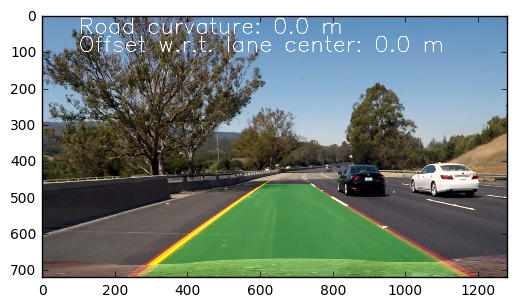

In [24]:
def generate_output_img(img_original, lane, curvature, lane_offset):
    # Copy warped image
    img_lines = np.zeros_like(img_original)
    img_free_space = np.zeros_like(img_original)

    # Draw lines
    draw_line(img_lines, lane.line_l, thickness = 50)
    draw_line(img_lines, lane.line_r, thickness = 50)    

    # Draw free space
    draw_free_space(img_free_space, lane)
    
    # Unwarp images
    img_free_space_unwarp = cv2.warpPerspective(img_free_space, Minv, (img_original.shape[1], img_original.shape[0])) 
    img_lines_unwarp = cv2.warpPerspective(img_lines, Minv, (img_original.shape[1], img_original.shape[0])) 

    # Blend with original image
    img_out = cv2.addWeighted(img_original, 1, img_lines_unwarp, 0.3, 0)
    img_out = cv2.addWeighted(img_out, 1, img_free_space_unwarp, 0.3, 0)
    
    # Print curvature and lane offset
    font = cv2.FONT_HERSHEY_SIMPLEX
    color = (255, 255, 255)
    scale = 2
    thickness = 2
    cv2.putText(img_out, "Road curvature: %.1f m" % curvature, (100, 50), font, scale, color, thickness)
    cv2.putText(img_out, "Offset w.r.t. lane center: %.1f m" % lane_offset, (100, 100), font, scale, color, thickness)    
    
    return img_out

plt.figure();
plt.imshow(generate_output_img(img_original, lane, 0, 0));
save_doc_img(generate_output_img(img_original, lane, 0, 0), 'main_visualization')

## Line Tracking

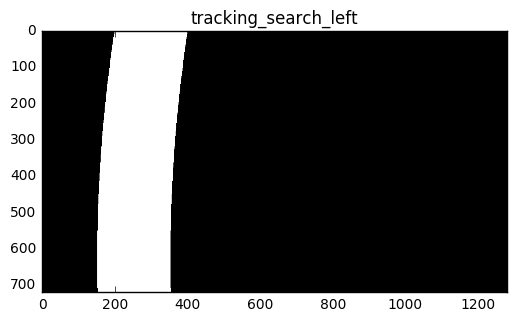

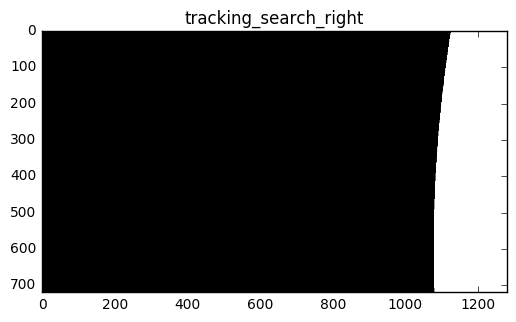

In [25]:
class LineTracker(object):
    def __init__(self, line, visualization_name = None):
        self.line = line
        self.visualization_name = visualization_name
        
    def track(self, img_warped):
        # Define search mask
        search_mask = self._create_search_mask(img_warped)
        
        # Mask image
        img_warped_masked = search_mask * img_warped        
        
        # Get line pixels
        points = np.squeeze(cv2.findNonZero(img_warped_masked));

        pixels_x = points[:,0]
        pixels_y = points[:,1]
                
        # Update line
        self.line.update(pixels_x, pixels_y)
        
    def _create_search_mask(self, img_warped):
        mask = np.zeros_like(img_warped)
        
        # Create lines to left and right of the actual line, with some offset
        offset = 100 # pixels
        
        fake_lane = Lane()
        fake_lane.line_l = self._offset_line_x(self.line, -offset)
        fake_lane.line_r = self._offset_line_x(self.line, offset)
        
        # Draw as in free space
        draw_free_space(mask, fake_lane, color = (1, 1, 1))        
        
        if self.visualization_name:
            plt.figure();
            plt.imshow(mask, cmap = 'gray')
            plt.title(self.visualization_name)
            save_doc_img(mask_to_rgb(mask), self.visualization_name)
        return mask
            
            
    def _offset_line_x(self, line, offset):
        # Copy line
        line_out = Line()
        line_out.coeffs = np.copy(line.coeffs)
        
        # Apply offset to the last coefficient
        line_out.coeffs[-1] = line_out.coeffs[-1] + offset
        
        return line_out

lt = LineTracker(line_l, 'tracking_search_left')
lt.track(img_mask)

lt = LineTracker(line_r, 'tracking_search_right')
lt.track(img_mask)

In [26]:
def track_lane(lane, img_mask):
    lt_l = LineTracker(lane.line_l)
    lt_l.track(img_mask)

    lt_r = LineTracker(lane.line_r)
    lt_r.track(img_mask)
    
    return lane

## Road Curvature

In [27]:
def compute_curvature(lane, img_shape):
    y_curvature = img_shape[0]
    return 0.5 * (lane.line_l.curvature(y_curvature) + lane.line_r.curvature(y_curvature))

y_curvature = img_mask.shape[0]
print('Curvature - left: %.1f m, right: %.1f m' % (lane.line_l.curvature(y_curvature),
                                                   lane.line_r.curvature(y_curvature)))
print('Final curvature: %.1f m' % (compute_curvature(lane, img_mask.shape)))

Curvature - left: 784.1 m, right: 963.7 m
Final curvature: 873.9 m


## Relative Vehicle Position

In [28]:
def compute_vehicle_position(lane, img_shape):
    return 0.5 * (lane.line_r.get_x_position(img_shape[0], img_shape[1]) + \
                  lane.line_l.get_x_position(img_shape[0], img_shape[1]))

print('Vehicle position: %.3f m' % compute_vehicle_position(lane, img_mask.shape))

Vehicle position: 0.424 m


## Visualizer

In [29]:
def create_debug_img(result_img, img_warped, img_mask, curvature, vehicle_position):
    # Declare output image, full HD
    img_out = np.zeros((1080, 1920, 3), dtype = np.uint8)
    
    # Place images inside img_out
    img_out[0:720, 0:1280,     :] = cv2.resize(result_img, (1280, 720))
    img_out[720:960, 0:320, :]    = cv2.resize(img_warped, (320,240))
    
    img_mask = np.dstack((img_mask, img_mask, img_mask)) * 255    
    img_out[720:960, 320:640 , :] = cv2.resize(img_mask, (320, 240))
    
    return img_out

## Complete pipeline

In [30]:
class LaneFindingPipeline:
    def __init__(self, debug = False):
        self.lane = Lane()
        self.debug = debug
        
    def run(self, img):
        # Undistort image
        img_undistort = undistort_img(img)

        # Get birds-eye view
        img_warped, M, Minv = get_birds_eye_view(img_undistort);

        # Mask using color and gradients
        img_mask = combined_mask(img_warped)

        # Extract lines
        if not self.lane.sanity_check(img_mask.shape):
            self.lane = extract_lane(img_mask)
        else:
            self.lane = track_lane(self.lane, img_mask)
            
        # Compute curvature and vehicle position
        curvature = compute_curvature(self.lane, img.shape)
        vehicle_position = compute_vehicle_position(self.lane, img.shape)

        # Create output image
        img_out = generate_output_img(img, self.lane, curvature, vehicle_position)        
        
        # Return
        if self.debug:
            img_out = create_debug_img(img_out, img_warped, img_mask, curvature, vehicle_position)
            
        return img_out

## Test on images

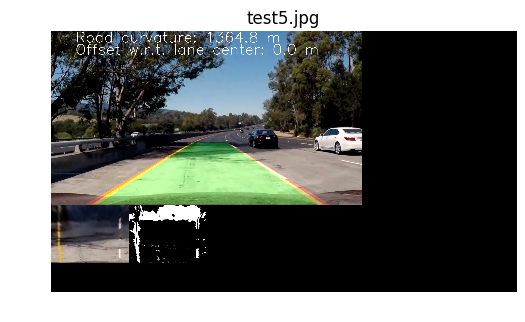

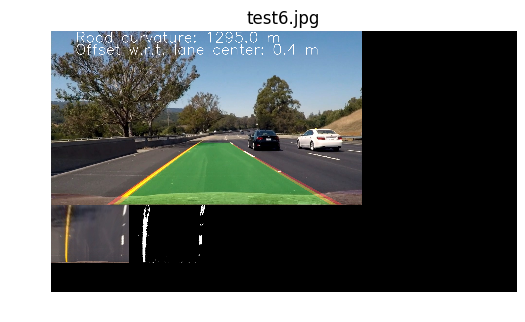

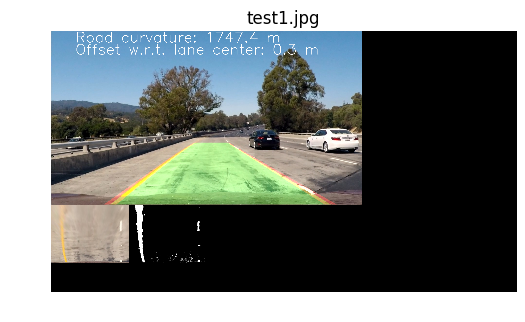

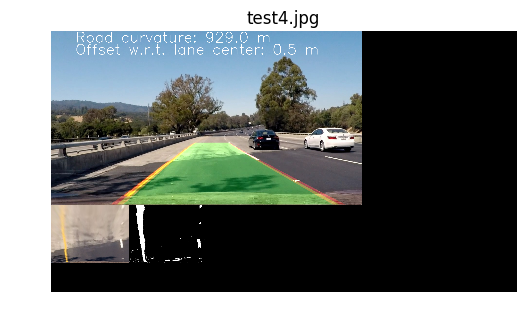

In [31]:
test_images = glob.glob('./test_images/*.jpg')

for img_path in test_images:
    _,img_name = os.path.split(img_path)
    
    # Read image
    img = mpimg.imread(img_path)
    
    # Create a new LaneFindingPipeline
    pipeline = LaneFindingPipeline(debug = True)
    
    # Run it on the image
    img_out = pipeline.run(img)
    
    # Display
    plt.figure();
    plt.imshow(img_out); 
    plt.axis('off');
    plt.title(img_name);
    
    # Save to disk
    mpimg.imsave(os.path.join(get_output_dir(), img_name), img_out)

## Test on videos

In [32]:
test_videos = glob.glob('./*_video.mp4')

for video in test_videos:
    # Create LaneFindingPipeline
    pipeline = LaneFindingPipeline(debug = True)
    
    # Read video
    clip = VideoFileClip(video)
    
    # Process video
    clip_processed = clip.fl_image(pipeline.run) #NOTE: this function expects color images!!
    
    # Save to disk
    _,video_name = os.path.split(video)
    out_name = os.path.join(get_output_dir(), video_name)
    clip_processed.write_videofile(out_name, audio=False)
    
    # Display in the notebook
    print(out_name)
    display(HTML("""<video width="640" height="360" controls><source src="{0}"></video>""".format(out_name)))

[MoviePy] >>>> Building video ./output_images/project_video.mp4
[MoviePy] Writing video ./output_images/project_video.mp4


  3%|▎         | 38/1261 [00:03<01:47, 11.40it/s]

KeyboardInterrupt: 